In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from pprint import pprint
import pylab

In [3]:
%matplotlib inline

In [4]:
exps = ['roberta-base', 'roberta-large']

metrics = {
    "CoLA":["mcc"],
    "MNLI":["acc"],
    "MNLI-MM":["acc"],
    "MRPC":["f1"],
    "QNLI":["acc"],
    "QQP":["f1"],
    "RTE":["acc"],
    "SST-2":["acc"],
    "STS-B":["spearmanr"],
    "WNLI":["acc"] #temp
}

def get_average_val(lines):
    reported = []
    for line in lines:
        if len(line.split('\t')) != 2:
            print('\t??', line)
        val = float(line.split('\t')[1])
        if val != 0:
            reported.append(val)
    out = 0
    if len(reported) != 0:
        reported.sort(reverse = True)
        candidates = [reported[0]]
        for j in range(1, len(reported)):
            if reported[j] > 0.9 * reported[0]:
                candidates.append(reported[j])
        out = np.mean(candidates)
        
    return out

In [5]:
real_all_tasks = {
    "roberta-base": ["CoLA","SST-2","MRPC","STS-B","QQP","MNLI", "MNLI-MM", "QNLI","RTE"],
    "roberta-large": ["CoLA", "MRPC", "RTE", "SST-2", "STS-B"]
}

result_folder = "mt_dnn_exp_results"
name_mapping = {
    "bert":"BERT",
    "roberta":"RoBERTa",
    "xlnet":"XLNet"
}

results = {}


results = {}

for task in real_all_tasks['roberta-base']:
    results[task] = {}
    task_metrics = metrics[task]

    task_results = {
        'base':{
            'all':[]
        },
        'large':{
            'all':[]
        }
    }
        
    for exp in exps:
        print(exp, task)
        for metric in task_metrics:
        
            # base metrics
            path_name = f"../../mt_dnn_exp_results/{exp}/{task}"
            f_name = path_name + f"/base-{metric}.txt"
            try:
                f = open(f_name, "r")
                try:
                    lines = f.read().splitlines()

                    if "base" in exp:
                        task_results['base']['all'].append(get_average_val(lines))
                    elif "large" in exp:
                        task_results['large']['all'].append(get_average_val(lines))

                except e:
                    print("failed to process 1", f_name, e)
                    if "base" in exp:
                        task_results['base']['all'].append(0)
                    elif "large" in exp:
                        task_results['large']['all'].append(0)
                        
            except:
#                 print("failed to open 1", f_name)
                if "base" in exp:
                    task_results['base']['all'].append(0)
                elif "large" in exp:
                    task_results['large']['all'].append(0)
                    

                    
            # no layer metrics

            fine_tuning_metrics = []
            f_name =path_name + f"/no_layer-{metric}.txt"
#             print(f_name)
            
            try:
                f=open(f_name, "r")
                
                try:

                    lines = f.read().splitlines()
                    fine_tuning_metrics.append(get_average_val(lines))
                
                except e:
#                     print("failed to process 2 ", f_name, e)
                    fine_tuning_metrics.append(0)

            except:
#                 print("failed to open 2", f_name)
                fine_tuning_metrics.append(0)

            # fine-tuned metrics

            if "base" in exp:
                num_layers = 12
            elif "large" in exp:
                num_layers = 24
            
            log_file_prefix=''
            for i in reversed(range(int(num_layers/2), num_layers)):
                log_file_prefix += str(i)
                f_name = path_name + f"/{log_file_prefix}-{metric}.txt"
#                 print(f_name)
                try:
                    f=open(f_name, "r")
                    try:                        
                        lines = f.read().splitlines()
                        fine_tuning_metrics.append(get_average_val(lines))
                        
                    except e:
                        
                        
#                         print("failed to process 3", f_name, e)
                        print(lines)
                        fine_tuning_metrics.append(0)
                except:
#                     print("failed to open 3", f_name)
                    fine_tuning_metrics.append(0)
                
                log_file_prefix +='_'

#             task_results[exp] = list(reversed(fine_tuning_metrics))

            
            if "base" in exp:
                task_results['base']['frozen'] = list(reversed(fine_tuning_metrics))
            elif "large" in exp:
                task_results['large']['frozen'] = list(reversed(fine_tuning_metrics))
                
        results[task][metric] = task_results

# print(results["QQP"]['acc']['large'])

roberta-base CoLA
roberta-large CoLA
roberta-base SST-2
roberta-large SST-2
roberta-base MRPC
roberta-large MRPC
roberta-base STS-B
roberta-large STS-B
roberta-base QQP
roberta-large QQP
roberta-base MNLI
roberta-large MNLI
roberta-base MNLI-MM
roberta-large MNLI-MM
roberta-base QNLI
roberta-large QNLI
roberta-base RTE
roberta-large RTE


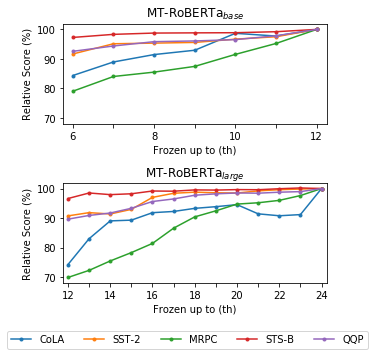

In [6]:
color_mapping = {
    "bert":'green',
    "roberta":'red',
    "BERT":'green',
    "roBERTa":'red',
}

y_label_mapping = {
    "mcc":'MCC',
    "f1":r'$F_1$',
    "acc":'Acc.',
    "spearmanr": r'$\rho$'
}



def draw_graph(ax, model_size, collected, tasks):
    x_axis = []
    
    if "base" in model_size:
        num_layers = 12
    elif "large" in model_size:
        num_layers = 24
    
    for i in range(int(num_layers/2), num_layers):
        if i%2==0:
            x_axis.append(i)
        else:
            x_axis.append('')
    x_axis.append(num_layers)

    
    for task in tasks['roberta-large']:
        metric = metrics[task][0]
        task_collected = collected[task][metric][model_size]

        y_data = [task_collected['all'][0]] + task_collected['frozen'][:-1]
        y_data.reverse()
        y_data_relative = [100*(x/y_data[-1]) for x in y_data]
        ax.plot(y_data_relative, '.-', label=task)
    
    ax.set_ylim(68, 102)
    ax.set_xticks(np.arange(1+len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-0.25, len(x_axis)-0.75)
    ax.set_xlabel("Frozen up to (th)")
    ax.set_ylabel("Relative Score (%)")
    
    subscript = "$_{base}$" if model_size=='base' else "$_{large}$"
    ax.set_title("MT-RoBERTa" + subscript)


# import seaborn as sns
# sns.set(style='white', font_scale=2.5)

scale = 1 / 1.4
fig, axes = plt.subplots(2, 1, figsize=[6.4*scale, 6.4 * scale])
draw_graph(axes[0], 'base', results, real_all_tasks)
draw_graph(axes[1], 'large', results, real_all_tasks)
axes[0].legend(real_all_tasks["roberta-base"],
           bbox_to_anchor=(-0.15/scale, -1.4/scale - 0.1),
           loc='upper left', ncol=5, borderaxespad=0.)
plt.tight_layout()

import os
os.system("mkdir -p images")
plt.savefig("images/MTRoBERTa.pdf", bbox_inches='tight')